In [1]:
from ase.io import read
import numpy as np
import os
from tqdm.auto import tqdm
from skmatter.sample_selection import DirectionalConvexHull as GCH
import pickle
from skmatter.preprocessing import KernelNormalizer
from skmatter.preprocessing import StandardFlexibleScaler
from skmatter.decomposition import PCovR
from rascal.representations import SphericalInvariants as SOAP
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge as KRR
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
#from dscribe.kernels.rematchkernel import REMatchKernel
from scipy.spatial.distance import cdist

def rmse(*x):
    return np.sqrt(mse(*x))

plt.rcParams['pdf.fonttype']=42

SMALL_FONT=10
MEDIUM_FONT=12
LARGE_FONT=16

ModuleNotFoundError: No module named 'dscribe'

# Load the frames and properties

In [2]:
frames = np.asarray(read('ice_w_props.xyz', ':'), dtype=object)
for frame in frames:
    frame.wrap(eps=1E-10)

energies = np.array([frame.info['energy [eV/H2O]'] for frame in frames])

indices = np.where(energies<-473.2)[0]

# Compute or Load the SOAP Representation

In [3]:
for frame in frames:
    mask = np.zeros(len(frame), dtype=bool)
    mask[np.where(frame.numbers==8)] = 1
    frame.arrays['center_atoms_mask'] = mask

In [4]:
hypers = {
    'interaction_cutoff': 5.0,
    'max_radial': 9,
    'max_angular': 6,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.5,
    'radial_basis': 'GTO',
    'normalize': False
}
soap = SOAP(**hypers)
lens = [
    len(
        np.where(
            f.arrays.get('center_atoms_mask', np.ones(len(frame),
                                                             dtype=bool)))[0])
    for f in frames
]
splits = [sum(lens[:i]) for i in range(1, len(lens))]

if not os.path.exists('soaps.npy'):
    manager = soap.transform(frames)
    xa_raw = manager.get_features(soap)
    np.save('soaps.npy', xa_raw)
else:
    xa_raw = np.load('soaps.npy')
i_splits = np.array_split(np.arange(xa_raw.shape[0]), splits)

In [5]:
x_scaler = StandardFlexibleScaler(column_wise=False).fit(xa_raw)

In [6]:
X_raw = np.array([x.mean(axis=0) for x in np.array_split(xa_raw, splits)])
X = x_scaler.fit_transform(X_raw)
X.shape

(15869, 1701)

If you would like to recompute the REMatch Kernel, which takes very long, you may uncomment the code cells below. Otherwise, please just reload `t_kpca.npy` and `y.npy` a few cells down.

In [7]:
'''rematch = REMatchKernel(metric='gaussian', gamma=0.1)
if os.path.exists('rematch.npy'):
    K = np.load('rematch.npy')
else:
    K = np.zeros((len(frames), len(frames)))
pbar_i = tqdm(total=len(frames))
pbar_j = tqdm(total=len(frames))
pbar_ij = tqdm(total=len(frames)*len(frames))'''

  0%|          | 0/15869 [00:00<?, ?it/s]

  0%|          | 0/15869 [00:00<?, ?it/s]

  0%|          | 0/251825161 [00:00<?, ?it/s]

In [8]:
'''for i in range(len(frames)):
    if np.count_nonzero(K[i]) < K[i].shape[0]:
        xi = x_scaler.transform(xa_raw[i_splits[i]])
        pbar_j.reset(total=len(frames)-i)
        for j in range(i, len(frames)):
            if K[i,j]==0:
                xj = x_scaler.transform(xa_raw[i_splits[j]])
                K[i,j] = K[j,i] = rematch.get_global_similarity(cdist(xi, xj))
            pbar_ij.update(1)
            if i!=j:
                pbar_ij.update(1)
            pbar_j.update(1)
        if i % 100==0:
            np.save('rematch.npy', K)
            clear_output()
            plt.imshow(K)
            plt.show()
    else:
        pbar_ij.update(len(frames)-i)
        pbar_ij.update(len(frames)-i-1)
    pbar_i.update(1)
    
np.save('rematch.npy', K)'''

In [9]:
'''y_scaler = StandardFlexibleScaler(column_wise=True)
y = y_scaler.fit_transform(energies.reshape(-1,1))
Kn = KernelNormalizer().fit_transform(K)'''

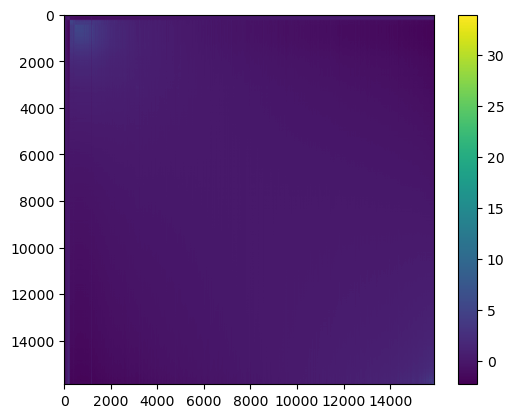

In [10]:
'''plt.imshow(Kn)
plt.colorbar()'''

# Conduct KPCA

/ssd/vprincip/code/miniconda3/envs/genshift2/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator KernelCenterer from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/ssd/vprincip/code/miniconda3/envs/genshift2/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator KernelPCA from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


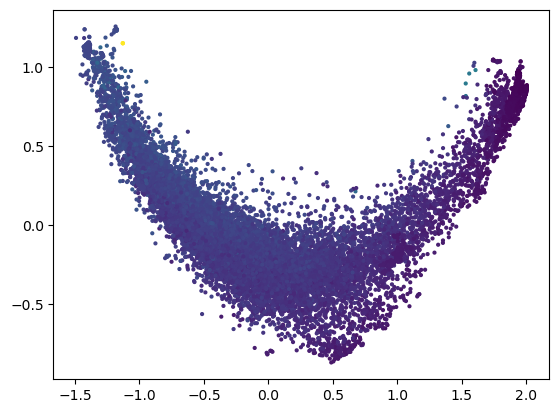

In [11]:
'''from sklearn.decomposition import KernelPCA

if not os.path.exists('kpca.sav'):
    kpca = KernelPCA(kernel='precomputed', n_components=2)
    kpca.fit(Kn)
    pickle.dump(kpca, open('kpca.sav', 'wb'))
else:
    kpca = pickle.load(open('kpca.sav', 'rb'))

t_kpca = kpca.transform(Kn)'''

In [5]:
#Reload t_kpca and y
with open('t_kpca.pickle', 'rb') as f:
    t_kpca = pickle.load(f)
with open('y.pickle', 'rb') as f:
    y = pickle.load(f)

In [ ]:
plt.scatter(t_kpca[:, 0], t_kpca[:, 1], c=y, s=4)

# Create GCH Plots Using KPCA Features

In [12]:
gch=GCH(low_dim_idx=[0,1])
gch.fit(t_kpca, y)
chull = gch.selected_idx_

chull = chull[np.argsort(t_kpca[chull,0])]

/ssd/vprincip/code/miniconda3/envs/genshift2/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Create 3D plot

<IPython.core.display.Javascript object>


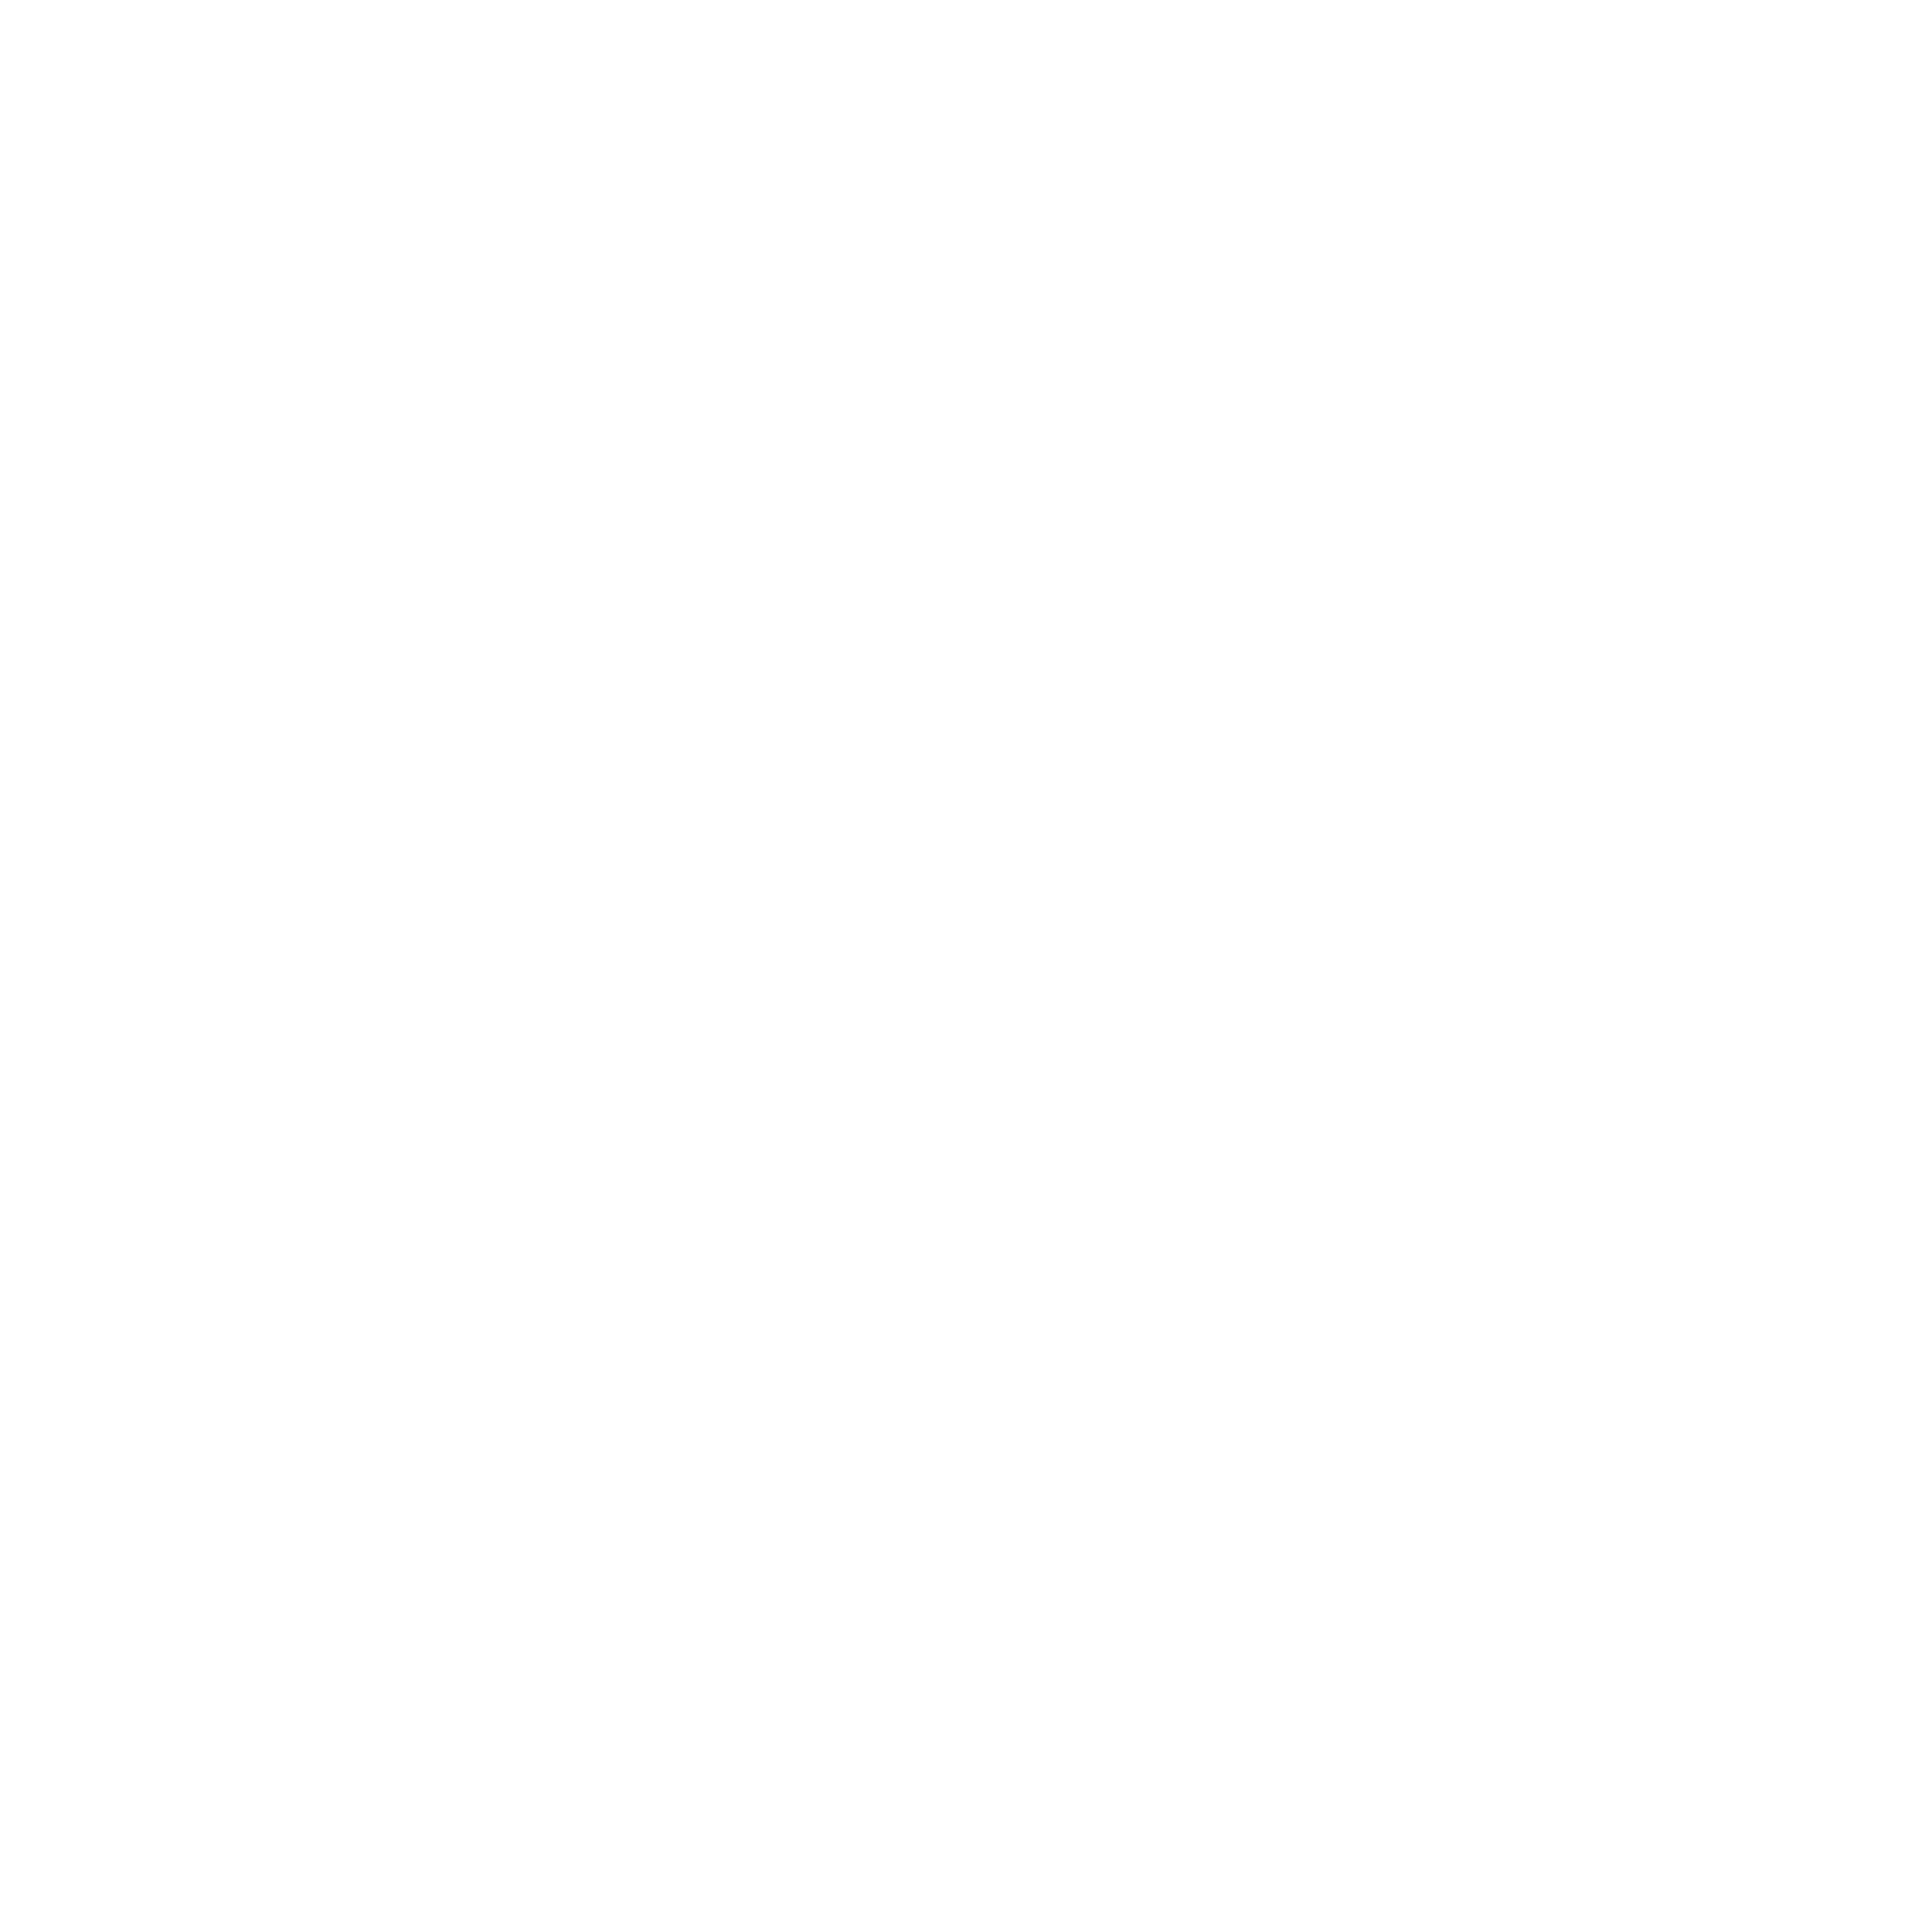

In [13]:
plt.rc('font', size=14)
%matplotlib notebook
hull_color = "white"
edge_color = "black"
point_color = "red"

from matplotlib import tri as mtri

fig = plt.figure(figsize=(7.5,7.5), dpi=300)
ax = fig.add_subplot(111, projection="3d")
ax.locator_params(nbins=6)
ax.locator_params(axis="y", nbins=6)
ax.locator_params(axis="z", nbins=4)
ax.tick_params(axis='z', which='major', pad=15)
ax.view_init(azim=-61.623376623376785, elev=18.63636363636363)
ax.plot_trisurf(
    t_kpca[chull, 0],
    t_kpca[chull, 1],
    y_scaler.inverse_transform(y).flatten()[chull],
    color=hull_color,
    edgecolor=edge_color,
    linewidth=0.2,
    alpha=0.8,
)
ax.scatter3D(
    t_kpca[:, 0],
    t_kpca[:, 1],
    y_scaler.inverse_transform(y),
    c=y_scaler.inverse_transform(y),
    # c=energies,
    # cmap="Greys",
    s=0.1,
    vmin=-473.6,
    vmax=-473.3,
    rasterized=True,
)
ax.scatter3D(
    t_kpca[chull, 0],
    t_kpca[chull, 1],
    y_scaler.inverse_transform(y).flatten()[chull],
    c=y_scaler.inverse_transform(y)[chull].flatten(),
    s=300,
    ec="k",
    # fc='none',
    vmin=-473.6,
    vmax=-473.3,
    marker=".",
)
ax.set_xlabel("$KPC_1$", labelpad=15)
ax.set_ylabel("$KPC_2$", labelpad=15)
ax.set_zlabel("Energies (eV/$H_2O$)", labelpad=30)

ax.set_zlim([-473.6, -473.25])

plt.subplots_adjust(left=-0.17, right=1.0, top=0.975, bottom=0.05)
plt.savefig('DCH.png')
plt.savefig('DCH.pdf')

## Create 2D Plot

In [14]:
xs = t_kpca.copy()[:,0]
ys = t_kpca.copy()[:,1]
distances = gch.score_samples(t_kpca, y)

selects = gch.selected_idx_
non_selects = [ii for ii, i in enumerate(xs) if ii not in selects]

/ssd/vprincip/code/miniconda3/envs/genshift2/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
#Get arrays of alphas, colours and sizes for plots (based on distance to the hull)
max_energy=-473.35
min_energy = -473.55
colours=[]
for energy in energies:
    if energy>max_energy:
        colours.append(max_energy)
    else:
        colours.append(energy)
colours=np.asarray(colours)

alphas = []
min_alpha = 0.05
max_alpha = 0.9
for dis in colours:
    if (1-((dis-min_energy)/(max_energy-min_energy)))<=min_alpha:
        alphas.append(min_alpha)
    elif (1-((dis-min_energy)/(max_energy-min_energy)))>=max_alpha:
        alphas.append(max_alpha)
    else:
        alphas.append(1-((dis-min_energy)/(max_energy-min_energy)))
alphas=np.asarray(alphas)

sizes = []
max_energy = -473.25
min_energy = -473.55
min_size = 1
max_size = 10
for energy in energies:
    if ((energy-min_energy)/(max_energy-min_energy))*max_size<=min_size:
        sizes.append(min_size)
    elif ((energy-min_energy)/(max_energy-min_energy))*max_size>=max_size:
        sizes.append(max_size)
    else:
        sizes.append(((energy-min_energy)/(max_energy-min_energy))*max_size)
sizes=np.asarray(sizes)

sizes = 1/sizes
sizes -=0.08
sizes *= 100

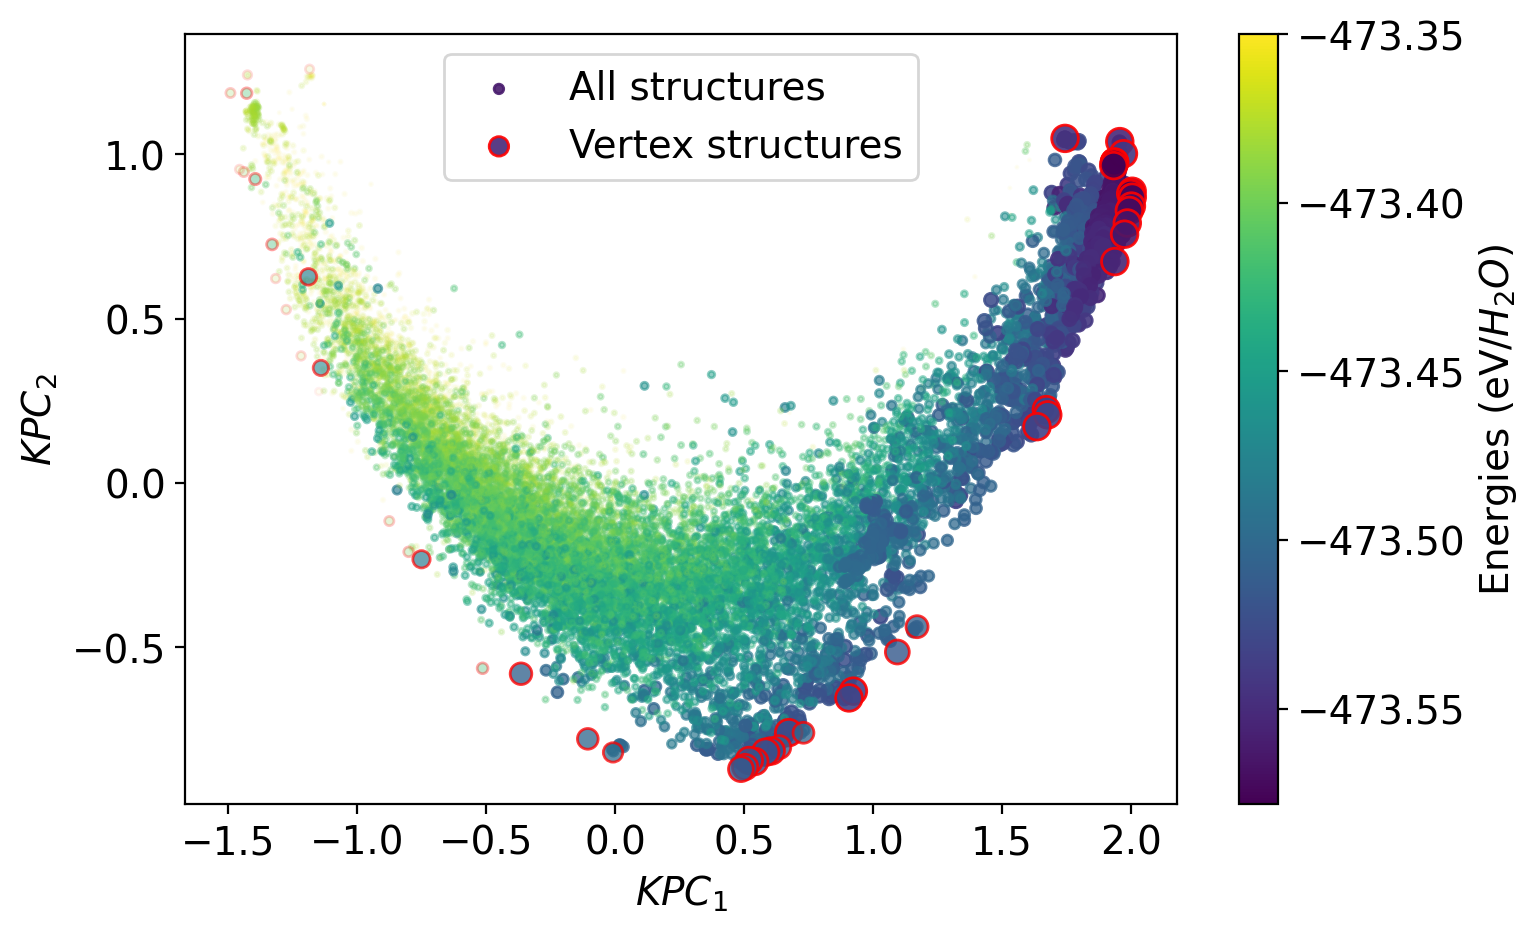

In [16]:
%matplotlib inline
plt.figure(figsize=(8,5), dpi=200)
plt.scatter(xs[non_selects],ys[non_selects],s=sizes[non_selects],c=colours[non_selects], alpha=alphas[non_selects], marker=".", label="All structures")
plt.scatter(xs[selects],ys[selects],s=sizes[selects],c=colours[selects],alpha=alphas[selects],marker="o", edgecolors="red", label="Vertex structures")
plt.xlabel("$KPC_1$")
plt.ylabel("$KPC_2$")
plt.colorbar(label="Energies (eV/$H_2O$)")
plt.legend()
plt.savefig('DCH_2D.png')
plt.savefig('DCH_2D.pdf')
plt.show()